In [41]:
from sentence_transformers import SentenceTransformer
from qdrant_client import QdrantClient
from qdrant_client import models
from qdrant_client.http.models import Distance, VectorParams, PointStruct 
from qdrant_client.models import Filter
from qdrant_client.http import models
import numpy as np
import pandas as pd
import configparser

In [42]:
config=configparser.ConfigParser()
config.read('../config.cfg')

model_name = "moussaKam/barthez"
encoder = SentenceTransformer(model_name_or_path=model_name)

No sentence-transformers model found with name C:\Users\gaelp/.cache\torch\sentence_transformers\moussaKam_barthez. Creating a new one with MEAN pooling.


In [43]:
QDRANT_HOST=config['QDRANT']['host']
QDRANT_PORT=config['QDRANT']['port']
QDRANT_API_KEY=config['QDRANT']['qdrant_api_key']

client = QdrantClient(url=QDRANT_HOST, 
                      port=QDRANT_PORT, 
                      api_key=QDRANT_API_KEY)

In [44]:
df = pd.read_csv('../data/processed/articles.csv', index_col=0, encoding='utf-8')

In [45]:
df = df.reset_index()

In [46]:
df.columns = ['newsId', 'author', 'title', 'publishedAt', 'content']

In [47]:
def generate_item_sentence(item: pd.Series, text_columns=["title"]) -> str:
    return ' '.join([item[column] for column in text_columns])

In [48]:
df["sentence"] = df.apply(generate_item_sentence, axis=1)
df["sentence_embedding"] = df["sentence"].apply(encoder.encode)

In [ ]:
client.create_collection(
    collection_name = "articles_fr_newsapi",
    vectors_config = models.VectorParams(
        size = encoder.get_sentence_embedding_dimension(),
        distance = models.Distance.COSINE,
    ),
)

In [50]:
metadata_columns = df.drop(["newsId", "sentence", "sentence_embedding"], axis=1).columns

def create_vector_point(item:pd.Series) -> PointStruct:
    """Turn vectors into PointStruct"""
    return PointStruct(
        id = item["newsId"],
        vector = item["sentence_embedding"].tolist(),
        payload = {
            field: item[field]
            for field in metadata_columns
            if (str(item[field]) not in ['None', 'nan'])
        }
    )

points = df.apply(create_vector_point, axis=1).tolist()

In [51]:
CHUNK_SIZE = 500
n_chunks = np.ceil(len(points)/CHUNK_SIZE)

for i, points_chunk in enumerate(np.array_split(points, n_chunks)):
    client.upsert(
        collection_name="articles_fr_newsapi",
        wait=True,
        points=points_chunk.tolist()
    )

In [52]:
query_text = "Macron"
query_vector = encoder.encode(query_text).tolist()

In [53]:
client.search(
    collection_name="articles_fr_newsapi",
    query_vector=query_vector,
    with_payload=["newsId", "title", "content"],
    query_filter=None
)

[ScoredPoint(id=69, version=1, score=0.46678478, payload={'content': 'La bagnole\xa0? «\xa0Moi, je ladore\xa0!\xa0», avait déclaré Emmanuel Macron lors dune interview télévisée le 24\xa0septembre. Cette passion a sans doute incité le chef de lEtat à annoncer lui-même, jeudi 14\xa0décemb… [+3356 chars]', 'title': 'Voiture électrique\xa0: une démocratisation difficile'}, vector=None, shard_key=None),
 ScoredPoint(id=22, version=1, score=0.43773925, payload={'content': 'Les funérailles du Pape émérite Benoît XVI\r\nLa dépouille de Joseph Ratzinger, pape de\xa02005 à\xa02013, a été exposée dans la basilique Saint-Pierre de Rome.Andreas SOLARO/AFP\r\nPour la première fois depui… [+11062 chars]', 'title': '20 photos marquantes de\xa02023'}, vector=None, shard_key=None),
 ScoredPoint(id=7, version=1, score=0.42466035, payload={'content': 'Depuis 2017\xa0et les révélations sur le producteur de cinéma prédateur Harvey Weinstein, la vague qui a libéré la parole des femmes victimes de violences s

## Affichage

In [55]:
import numpy as np
import ast

# Convert embeddings from CSV str type to NumPy Array
embedding_array = np.array(
    df['sentence_embedding'].to_list()
)

In [64]:
query = "Guerre en Ukraine"
query_embedding_response = np.array(
    encoder.encode(query)
)

In [65]:
from scipy.spatial.distance import cdist

df['distance'] = cdist(
    embedding_array,
    [query_embedding_response]
)

In [66]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(df[['distance']])

df['normalised'] = scaler.transform(df[['distance']])

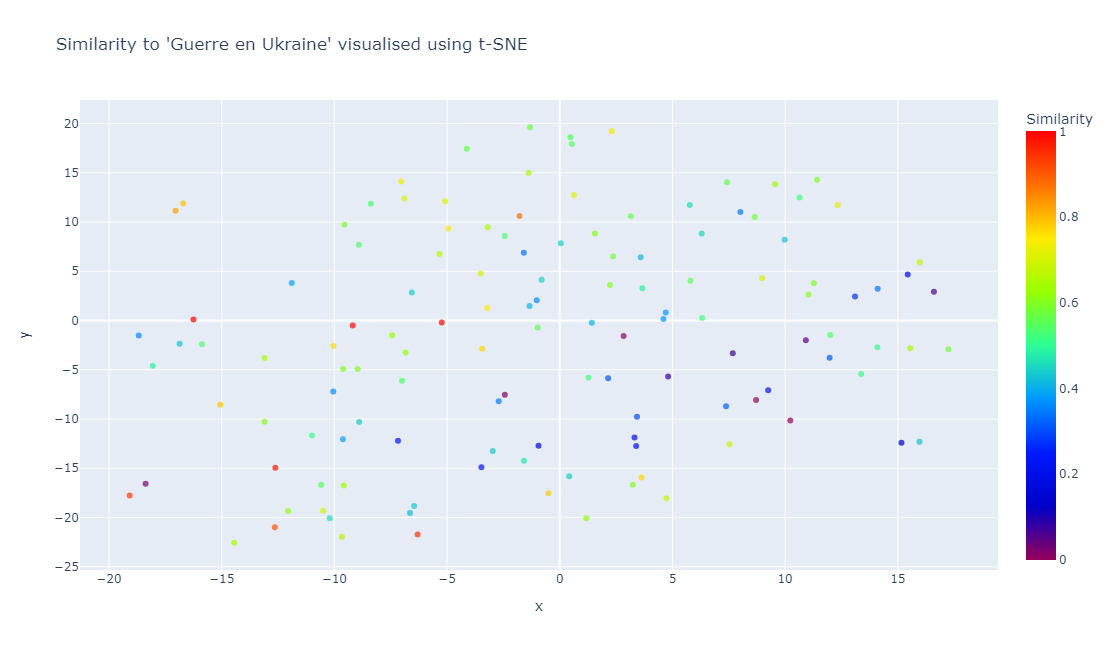

In [67]:
import plotly.express as px
from sklearn.manifold import TSNE

# Create a t-SNE model
tsne_model = TSNE(
    n_components = 2,
    perplexity = 15,
    random_state = 42,
    init = 'random',
    learning_rate = 200
)
tsne_embeddings = tsne_model.fit_transform(embedding_array)

# Create a DataFrame for visualisation
visualisation_data = pd.DataFrame(
    {'x': tsne_embeddings[:, 0],
     'y': tsne_embeddings[:, 1],
     'title':df['title'],
     'Similarity': df['normalised'].round(3)}
)

# Create the scatter plot using Plotly Express
plot = px.scatter(
    visualisation_data,
    x = 'x',
    y = 'y',
    color = 'Similarity',
    hover_name='title',
    color_continuous_scale = 'rainbow',
    opacity = 0.7,
    title = f"Similarity to '{query}' visualised using t-SNE"
)

plot.update_layout(
    width = 1000,
    height = 650
)

# Show the plot
plot.show()